# Indexing Optimization

Part 1：Multi-representation Indexing（多表征索引 / MultiVectorRetriever）

Part 2：RAPTOR（层级聚合+摘要树索引）

Part 3：ColBERT（token 级别检索，Late Interaction）

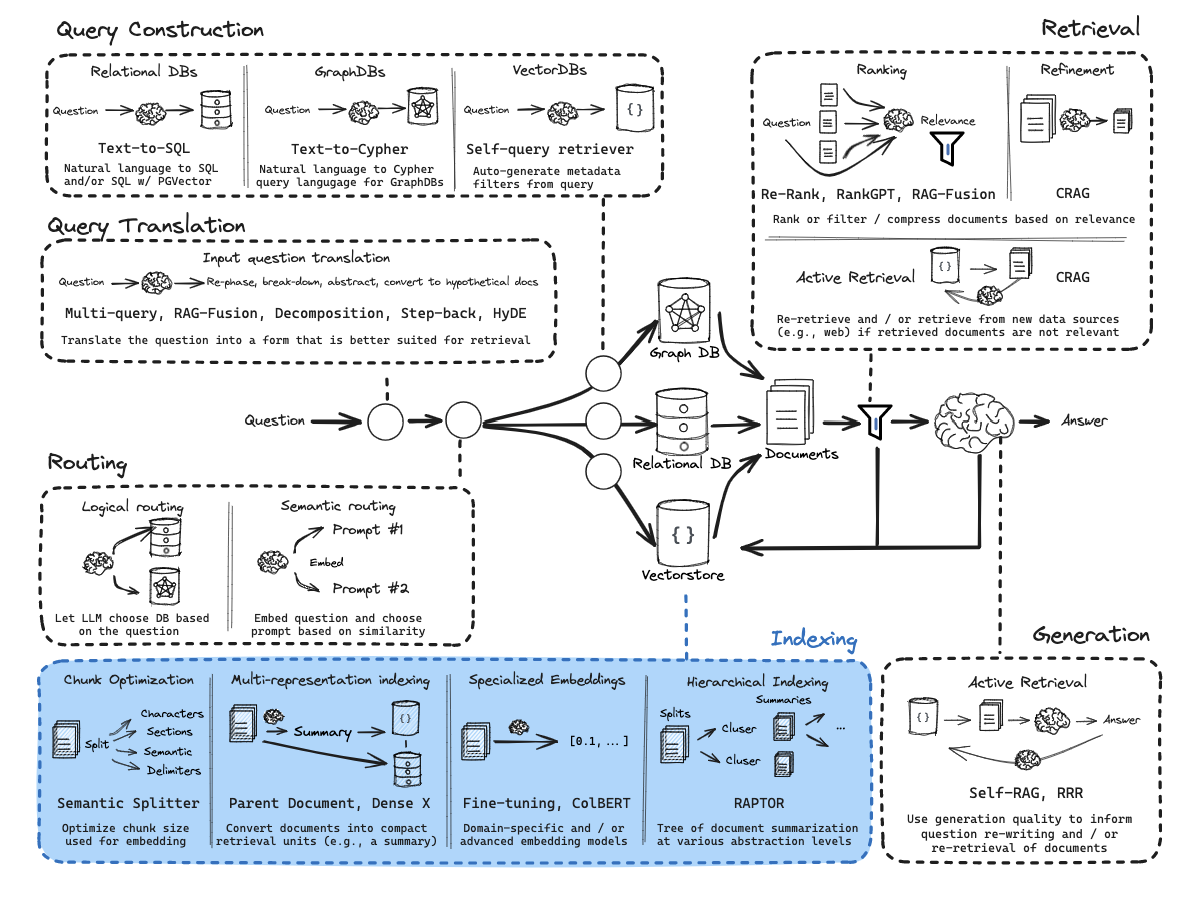

## <mark>1. Multi-representation Indexing（多表征索引）</mark>

问题：原文很长很杂，直接做 embedding 检索可能不稳定。

比如我们有一篇很长的博客（几千字）：

- 里面有很多段落：agent、memory、tool use、planning……
- 用户问：“Memory in agents 是什么？”
- 我们希望检索系统能更快更准定位“memory”相关部分

但如果我们把原文直接切 chunk 做 embedding：

- 有时 chunk 太碎，语义不完整
- 有时 chunk 太长，embedding 不够聚焦
- 有时我们想用“摘要/标题/图片说明”等不同表示法来检索

Multi-representation（多表征）的核心想法是：

同一份“父文档（parent doc）”，可以生成多个“子表征（child representations）”用于检索；

检索命中子表征后，再把对应的父文档取回来给 LLM。

可以理解成：“用摘要去搜，用全文去答。”

---
<mark>核心思想：</mark>

**“检索”和“回答”对文本内容的需求是不同的，因此需要为同一份文档建立多种不同形式的索引。**


<mark>工作原理：</mark>

多表征索引不再是“一份文档对应一个向量”，而是为同一份原始文档生成 **多个层级的“替身”** 进行检索。

1、**生成表征层（用于检索）：**
* **摘要索引（Summary Index）：** 使用 LLM 为每个长文档或大段落生成一段精炼的**摘要**。将摘要转化为向量存入向量数据库。摘要通常更能捕捉文档的“神髓”，与用户问题的语义更接近。
* **假设性问题索引（Hypothetical Questions）：** 为文档生成几个可能被问到的问题，并索引这些问题。当用户提问时，实际上是在匹配“相似的问题”。
* **原子命题索引（Propositions）：** 将文档拆解为一个个独立的、含义完整的简单句（命题）进行索引。


2、**存储关联层（用于生成）：**
* 将上述“替身”（摘要、问题、命题）与**原始完整文档**（或包含上下文的大块文本）通过唯一的 ID 关联起来。


3、**检索逻辑：**
* **第一步：** 用户提问 → 与“替身”向量匹配 → 命中某个摘要或命题。
* **第二步：** 系统根据关联 ID，不向大模型提供那个简短的摘要，而是直接提取关联的**完整原始文档**。

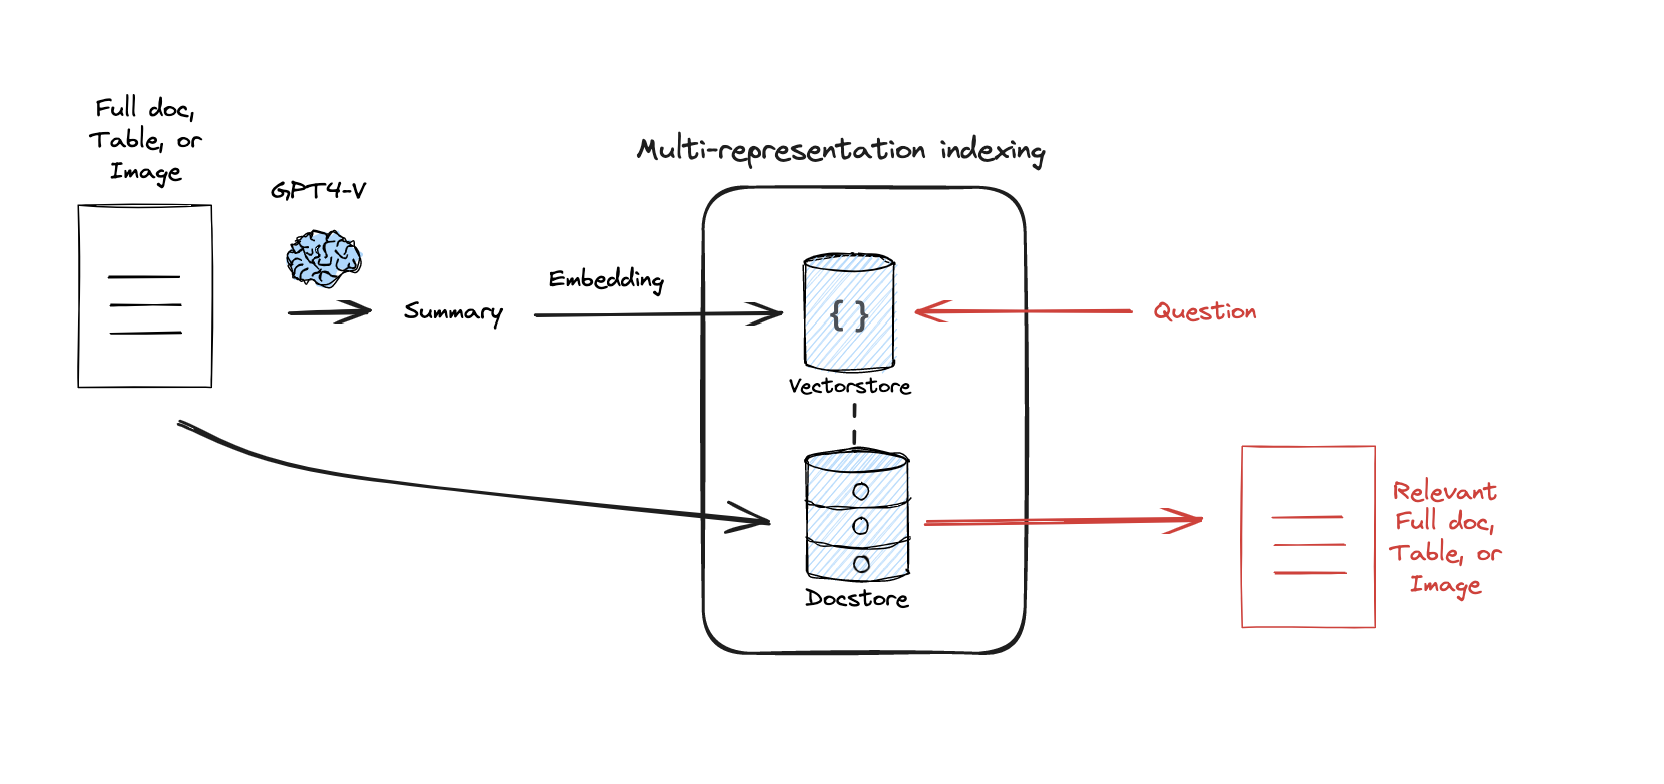

In [1]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_BASE_URL = os.getenv("OPENAI_BASE_URL")

DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
DEEPSEEK_BASE_URL = os.getenv("DEEPSEEK_BASE_URL")

In [2]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

loader = WebBaseLoader("https://lilianweng.github.io/posts/2024-02-05-human-data-quality/")
docs.extend(loader.load())

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [ ]:
import uuid

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
# from langchain_openai import ChatOpenAI
from langchain_deepseek import ChatDeepSeek

llm = ChatDeepSeek(model="deepseek-chat")

chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | llm
    | StrOutputParser()
)

# 最大并发数：最多启动 5 个任务（线程）
summaries = chain.batch(docs, {"max_concurrency": 5})

In [ ]:
! pip install langchain-chroma

In [ ]:
from langchain_core.stores import InMemoryByteStore
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
# from langchain_classic.retrievers import MultiVectorRetriever
from langchain_classic.retrievers.multi_vector import MultiVectorRetriever

embed = HuggingFaceEmbeddings(
    model_name=r"E:\users\hwy\LLMs-Technology-Projects\models\all-MiniLM-L6-v2",
    model_kwargs={"device": "cpu"}
)

# 初始化向量库 (存储摘要)
vectorstore = Chroma(collection_name="summaries", embedding_function=embed)

# 初始化原始文档存储层
store = InMemoryByteStore()
id_key = "doc_id"

# 定义检索器
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

# 创建摘要文档对象，metadata 中关联原始文档 ID
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

# 将摘要及其向量存入 Chroma
retriever.vectorstore.add_documents(summary_docs)
# 将原始文档存入存储层 (注意：mset 需要字节或序列化后的文档，
# 如果 docs 是 Document 对象，需要确保存储逻辑一致)
retriever.docstore.mset(list(zip(doc_ids, docs)))

C:\Users\后文越\AppData\Local\Temp\ipykernel_9680\2773212570.py:16: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="summaries", embedding_function=embed)


In [9]:
query = "Memory in agents"
sub_docs = vectorstore.similarity_search(query, k=1)
sub_docs[0]

Document(metadata={'doc_id': '229e1676-3d96-4ddf-811b-b75e764ee1ea'}, page_content='This document is a comprehensive blog post titled "LLM Powered Autonomous Agents" by Lilian Weng, published on June 23, 2023. It explores the architecture and components of building autonomous agents using Large Language Models (LLMs) as their core "brain."\n\nHere is a summary of the key points:\n\n**Core Concept:** LLMs can be used as controllers for autonomous agents that can plan, remember, and use tools to solve complex problems beyond simple text generation. Examples like AutoGPT and BabyAGI are cited as early proof-of-concepts.\n\n**Agent System Overview:**\nThe proposed agent system has three main components working with the LLM:\n\n1.  **Planning:** The agent breaks down large tasks into smaller subgoals (task decomposition) and can reflect on and refine its past actions to improve (self-reflection). Techniques discussed include Chain of Thought (CoT), Tree of Thoughts, ReAct, and Reflexion.\n\

---

## <mark>2. RAPTOR（层级摘要树索引）</mark>

当我们的文档库很大、文档很长时，仅靠“平铺的 chunks”会遇到一个大问题：

* 用户问的是一个**需要全局理解**的问题
  例如：“这篇文章总体上怎么组织 agent 的能力模块？”
* 平铺检索很可能只捞到几个局部段落，缺少“全局结构”

**RAPTOR 的核心思路：**

> 把文档 chunks 先聚类 → 对每个簇生成摘要 → 摘要再聚类再摘要 → 形成一棵层级树（从细节到全局）。

最终索引里既有：

* 叶子节点：细节 chunks（具体事实）
* 中间/根节点：更抽象的摘要（全局概念）

**检索时**：既能找到细节，也能找到“更高层的解释”。

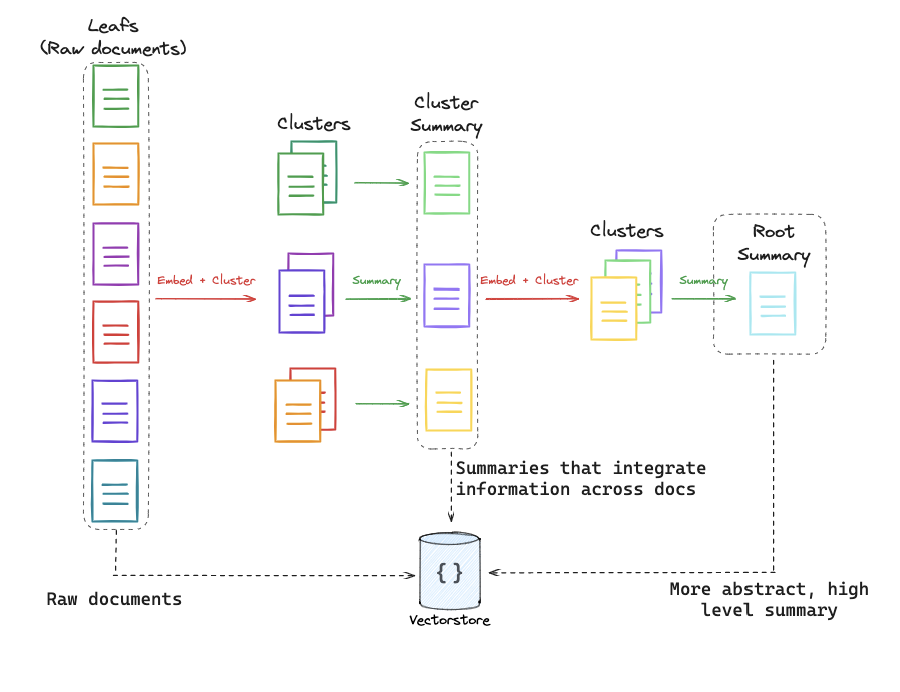

---

## <mark>3. ColBERT（token 级别检索，RAGatouille）</mark>

传统向量检索（dense embedding）通常是：

* 整段文本 → 1 个向量
* 查询 → 1 个向量
* 算相似度

但这会丢掉很多“细粒度匹配”的信息。

**ColBERT 的核心特点：**

> 为文档里的每个 token 都生成向量；查询也是每个 token 一个向量；
> 用一种叫 “MaxSim / Late Interaction” 的方式对齐匹配。

直觉上：
它更像在做“细颗粒的语义匹配”，对一些需要精确对齐的问法更强。

In [ ]:
! pip install ragatouille

In [ ]:
from ragatouille import RAGPretrainedModel
RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

In [ ]:
# 我们这里就直接假设有一个 full_document，这是一个纯文本内容
full_document = ""

# 建立索引
RAG.index(
    collection=[full_document],
    index_name="Miyazaki-123",
    max_document_length=180,
    split_documents=True
)

# ColBERT 会计算这些文本块中每个词的向量，并构建一个高度优化的索引文件，存储在磁盘上。

In [ ]:
# 原生检索
# 使用 RAGatouille 自带的方法进行搜索，返回最相关的 3 个文本片段及其评分
results = RAG.search(query="What animation studio did Miyazaki found?", k=3)
results

In [ ]:
# 转换为 LangChain 检索器
# 将 RAGatouille 的能力封装成 LangChain 标准的 Retriever 接口
retriever = RAG.as_langchain_retriever(k=3)
retriever.invoke("What animation studio did Miyazaki found?")